# Task 2 : Data Modeling
Based on the EDA from Task 1, we used the knowledge gained by our findings in the Exploration task to model our baseline model with minimal preprocessing using the wine dataset, provided in the first task. Afterwards, based on the scores we gathered, we preprocessed the data set by identifying the data quality issues and handling them.
- Feature und Instance Selection?
We then went on to define different pipelines with three different dataframes where we examined three different analysis approaches (univariate, multivariate and a combination of both) considering outliers and noise.

## To decide and evaluating our different model options:
  - Implementation of GridSearchCV, which should consider:
    - Function to log our results in a JSON file, where:
        - preprocesssing steps were conducted
        - Hyper-Parameters of the preprocessing methods/ algorithms are included
        - Our algorithm that is to be applied is modeled
        - and the Hyper-Parameters of the modeling algorithm
    - Visualization of our results


In our case we first started experimenting with classification, but we were not able to get over 62% and the split data set to help us predict which type of wine we have was not functioning the way we wanted.
We thought about the characteristics of the data set again and decided that it was more plausible to explain which input variables are the most significant for the influence of the output variable.

Also, here we need to take into account that our dataset can be quantified or measured numerically, and therefore it has quantitative features/ continuous variables.

Regression models are  well-suited for predicting continuous variables, whereas classification models are better suited for predicting categorical variables. Additionally, having a large number of observations (4000 rows) and a small number of features (16+1 label) makes it a good choice as it allows for a sufficient amount of data to train the model while still allowing for easy interpretability and understand of the model's predictions. Additionally, the fact that the data is numerical in nature, with a small number of outliers and missing values, makes it a good candidate for regression.

# Table of Content

1. [Import and Data Loading](#import-and-data-loading),
2. [Standard Pre-Processing](#standard-pre-processing),
    2.1 [MissingValues](#missing-values),
3. [Baseline Regression Models](#baseline-regression-models),
    3.1 [Classification Models](#classification-models),
    3.2 [Regression Models](#regression-models),
4. [Preprocessing](#preprocessing),
    4.1 [Separate](#conclusion-missing-values),
5. [Definition Pipelines](#definition-pipelines),
6. [Reading JSON preprocessing parameters, models and preprocessing](#reading-json-preprocessing-parameters-models-and-preprocessing),
    6.1 [Outliers without Gamay](#outliers-without-gamay),
7. [Best R^2 and MSE: RandomForestRegressor](#best-r2-and-mse:-randomforestregressor)
8. [RandomizedSearchCV](#randomizedsearchcv)

In [40]:
import time
import warnings
from datetime import datetime
from functions import missing_value_handling, remove_multivariate_outlier, remove_univariate_outliers, uni_multi_variate_outlier, normalize, standardize, noise_filtering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from typing import Dict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from onedal.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
import joblib
warnings.filterwarnings('ignore')

date_time = datetime.now().strftime("%d.%m.%Y, %H:%M:%S")

Loading data and standard preprocessing

In [ ]:
# Read CSV file to load data
df_wine = pd.read_csv('wine_training.csv', sep=';', index_col='Unnamed: 0')

# Changing column names -> space to underscore
df_wine.columns = df_wine.columns.str.replace(' ', '_')

# Standard Preprocessing

- Missing Value Handling

In [41]:
df_wine = missing_value_handling(df_wine)

# Baseline Regression Models

For diffeerent regressions and classification

Split Train Test:

In [42]:
X = df_wine.drop(['wine_type', 'quality'], axis = 1)
y = df_wine['quality']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size=.25, random_state=5)

## Abandoned approach: Classification

In [43]:
from typing import Dict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from onedal.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

classification_models = [LogisticRegression(),RandomForestClassifier(),ExtraTreesClassifier(),SVC(C=1, kernel='rbf'),GaussianNB()]


kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms


results = []
for model in classification_models:
    results.append(cross_val_score(model, X_train_base, y = y_train_base, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []

for cv_result in results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":['LogRegression','RandomForestClassifier','ExtraTreesClassifier','SVC','GaussianNB']})
print("Pipeline:")

print(cv_res)

Pipeline:
   CrossValMeans  CrossValerrors               Algorithm
0       0.434774        0.018629           LogRegression
1       0.608928        0.019456  RandomForestClassifier
2       0.623605        0.020252    ExtraTreesClassifier
3       0.437438        0.001075                     SVC
4       0.456781        0.030462              GaussianNB


## Pursued approach: Regression

In [44]:
regression_models = [LinearRegression(),LinearSVR(random_state = 42),KNeighborsRegressor(),RandomForestRegressor(random_state = 42), GradientBoostingRegressor(random_state = 42),DecisionTreeRegressor(random_state = 42)]

def baseline_regression_model(reg_models, X_train, X_test, y_train, y_test):

    # Create an empty list to store the models
    models = []

    for reg in reg_models:
        reg.fit(X_train, y_train)
        # Append the model to the list
        models.append(reg)
        # Predict on the training data
        y_pred = reg.predict(X_test)
        #print(len(y_pred))
        #print(len(y_pred))
        # Calculate the mean squared error and R-squared
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        # Print the results
        print("Regularization parameter:", reg)
        print("Mean squared error:", mse)
        print("R-squared:", r2)

baseline_regression_model(regression_models, X_train_base, X_test_base, y_train_base, y_test_base)

Regularization parameter: LinearRegression()
Mean squared error: 113.88239797806641
R-squared: -0.00481638430081599
Regularization parameter: LinearSVR(random_state=42)
Mean squared error: 113.36805323569745
R-squared: -0.0002781761713135378
Regularization parameter: KNeighborsRegressor()
Mean squared error: 127.88904904904905
R-squared: -0.12840100084549566
Regularization parameter: RandomForestRegressor(random_state=42)
Mean squared error: 122.76703273273272
R-squared: -0.08320801223032803
Regularization parameter: GradientBoostingRegressor(random_state=42)
Mean squared error: 119.88500738123382
R-squared: -0.05777909305956941
Regularization parameter: DecisionTreeRegressor(random_state=42)
Mean squared error: 264.07107107107106
R-squared: -1.3299732315364676


# Further preprocessing

Missing Values are already handled

1. Remove 99 quality values (skewing predictions)

In [45]:
df_wine_clean = df_wine[df_wine.quality != 99]
df_wine_clean

,wine_type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,magnesium,flavanoids,minerals,calcium,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,Pinot noir,5.8,0.15,0.49,1.1,76.729301,894.94,186.639301,109.91,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,5
1,Merlot,6.6,0.25,0.32,5.6,4.795712,1160.95,251.875712,247.08,0.039,15.0,68.0,0.99163,2.96,0.52,11.1,6
2,Chardonnay,6.7,0.21,0.34,1.5,85.193710,789.82,304.703710,219.51,0.035,45.0,123.0,0.98949,3.24,0.36,12.6,7
3,Merlot,8.3,0.28,0.27,17.5,11.976525,777.86,237.586525,225.61,0.045,48.0,253.0,1.00014,3.02,0.56,9.1,6
4,Merlot,7.5,0.42,0.19,6.9,5.599673,785.72,95.399673,89.80,0.041,62.0,150.0,0.99508,3.23,0.37,10.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Cabernet Sauvignon,6.4,0.23,0.37,7.9,92.701914,1143.32,318.791914,226.09,0.050,60.0,150.0,0.99488,2.86,0.49,9.3,6
3996,Cabernet Sauvignon,7.0,0.22,0.26,9.2,94.807955,863.32,322.107955,227.30,0.027,37.0,122.0,0.99228,3.06,0.34,12.5,8
3997,Merlot,7.5,0.26,0.30,4.6,50.112474,831.67,360.872474,310.76,0.027,29.0,92.0,0.99085,3.15,0.38,12.0,7
3998,Chardonnay,6.3,0.43,0.32,8.8,84.805688,1300.32,328.915688,244.11,0.042,18.0,106.0,0.99172,3.28,0.33,12.9,7


2. Separate Gamay and No-Gamay

In [46]:
df_wine_no_gamay = df_wine_clean[df_wine_clean["wine_type"]!="Gamay"].copy()
df_wine_gamay = df_wine_clean[df_wine_clean["wine_type"]=="Gamay"].copy()

3. OneHotEncode Wine Type for df_wine_clean, df_wine_no_gamay
4. Drop Wine Type for df_wine_gamay

In [47]:
df_wine_gamay = df_wine_gamay.copy().drop(columns=["wine_type"])
df_wine_gamay

# One Hot Encoding
wine_type_array = df_wine_no_gamay["wine_type"].to_numpy()

ohe = OneHotEncoder(sparse=False)
wine_type_transformed = ohe.fit_transform(wine_type_array.reshape(-1, 1))  # 1d array -> 2d array
df_wine_no_gamay[ohe.categories_[0]] = wine_type_transformed
df_wine_no_gamay = df_wine_no_gamay.copy().drop(columns=["wine_type"])
#df_wine_no_gamay

# OneHotEncoding df_clean
wine_type_array = df_wine_clean["wine_type"].to_numpy()

ohe = OneHotEncoder(sparse=False)
wine_type_transformed = ohe.fit_transform(wine_type_array.reshape(-1, 1))  # 1d array -> 2d array
df_wine_clean[ohe.categories_[0]] = wine_type_transformed
df_wine_clean = df_wine_clean.copy().drop(columns=["wine_type"])
df_wine_clean

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,magnesium,flavanoids,minerals,calcium,chlorides,free_sulfur_dioxide,...,density,pH,sulphates,alcohol,quality,Cabernet Sauvignon,Chardonnay,Gamay,Merlot,Pinot noir
0,5.8,0.15,0.49,1.1,76.729301,894.94,186.639301,109.91,0.048,21.0,...,0.99290,3.19,0.48,9.2,5,0.0,0.0,0.0,0.0,1.0
1,6.6,0.25,0.32,5.6,4.795712,1160.95,251.875712,247.08,0.039,15.0,...,0.99163,2.96,0.52,11.1,6,0.0,0.0,0.0,1.0,0.0
2,6.7,0.21,0.34,1.5,85.193710,789.82,304.703710,219.51,0.035,45.0,...,0.98949,3.24,0.36,12.6,7,0.0,1.0,0.0,0.0,0.0
3,8.3,0.28,0.27,17.5,11.976525,777.86,237.586525,225.61,0.045,48.0,...,1.00014,3.02,0.56,9.1,6,0.0,0.0,0.0,1.0,0.0
4,7.5,0.42,0.19,6.9,5.599673,785.72,95.399673,89.80,0.041,62.0,...,0.99508,3.23,0.37,10.0,6,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,6.4,0.23,0.37,7.9,92.701914,1143.32,318.791914,226.09,0.050,60.0,...,0.99488,2.86,0.49,9.3,6,1.0,0.0,0.0,0.0,0.0
3996,7.0,0.22,0.26,9.2,94.807955,863.32,322.107955,227.30,0.027,37.0,...,0.99228,3.06,0.34,12.5,8,1.0,0.0,0.0,0.0,0.0
3997,7.5,0.26,0.30,4.6,50.112474,831.67,360.872474,310.76,0.027,29.0,...,0.99085,3.15,0.38,12.0,7,0.0,0.0,0.0,1.0,0.0
3998,6.3,0.43,0.32,8.8,84.805688,1300.32,328.915688,244.11,0.042,18.0,...,0.99172,3.28,0.33,12.9,7,0.0,1.0,0.0,0.0,0.0


This results in three dataframes to be used for modelling:
- df_wine_clean, containing all wines
- df_wine_no_gamay
- df_wine_gamay

# Defining preprocessing pipelines

The pipelines implement the following preprocessing steps:
- `pipeline1`: Univariate outliers and noise filtering
- `pipeline2`: Multivariate outliers and noise filtering
- `pipeline3`: Univariate outliers, multivariate outliers and noise filtering

In [51]:
# univariate outlier + noise
def pipeline1(df, input_df=""):
    temp_df=df.copy()
    temp_df = remove_univariate_outliers(temp_df)
    temp_df = noise_filtering(temp_df, 1)
    X = temp_df.drop('quality', axis='columns')
    y = temp_df['quality']
    # split off some data for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return {
        'X': X,
        'y': y,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'input_df': input_df,
        'preprocessing_steps': 'univariate outlier + noise'
    }
pipeline1_clean = pipeline1(df_wine_clean, "df_wine_clean")
pipeline1_no_gamay = pipeline1(df_wine_no_gamay, "df_wine_no_gamay")
pipeline1_gamay = pipeline1(df_wine_gamay, "df_wine_gamay")

# multivariate outlier + noise
def pipeline2(df, input_df=""):
    temp_df=df.copy()
    temp_df = remove_multivariate_outlier(temp_df).drop(columns=["outliers"])
    #print(temp_df)
    temp_df = noise_filtering(temp_df, 1)
    X = temp_df.drop('quality', axis='columns')
    y = temp_df['quality']
    # split off some data for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return {
        'X': X,
        'y': y,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'input_df': input_df,
        'preprocessing_steps': 'multivariate outlier + noise'
    }
pipeline2_clean = pipeline2(df_wine_clean, "df_wine_clean")
pipeline2_no_gamay = pipeline2(df_wine_no_gamay, "df_wine_no_gamay")
pipeline2_gamay = pipeline2(df_wine_gamay, "df_wine_gamay")

# uni+multivariate outlier + noise
def pipeline3(df, input_df=""):
    temp_df=df.copy()
    temp_df = uni_multi_variate_outlier(temp_df).drop(columns=["outliers"])
    temp_df = noise_filtering(temp_df, 1)
    X = temp_df.drop('quality', axis='columns')
    y = temp_df['quality']
    # split off some data for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return {
        'X': X,
        'y': y,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'input_df': input_df,
        'preprocessing_steps': 'uni-multivariate outlier + noise'
    }
pipeline3_clean = pipeline3(df_wine_clean, "df_wine_clean")
pipeline3_no_gamay = pipeline3(df_wine_no_gamay, "df_wine_no_gamay")
pipeline3_gamay = pipeline3(df_wine_gamay, "df_wine_gamay")


Predictions for the different dataframes are to be made using every pipeline:

In [52]:
pipelines_clean = [pipeline1_clean,pipeline2_clean,pipeline3_clean]

pipelines_no_gamay = [pipeline1_no_gamay, pipeline2_no_gamay, pipeline3_no_gamay]

pipelines_gamay =[pipeline1_gamay, pipeline2_gamay, pipeline3_gamay]

pipelines = [pipeline1_clean,pipeline2_clean,pipeline3_clean, pipeline1_no_gamay, pipeline2_no_gamay, pipeline3_no_gamay, pipeline1_gamay, pipeline2_gamay, pipeline3_gamay]

# Grid search

## Logging

The result and composition of each combination of model and preprocessing steps are being documented in `logging.log` following this style:

``15.01.2023, 16:51:27: Input dataframe: df_wine_gamay, Preprocessing: univariate outlier + noise``<br>
``15.01.2023, 16:51:27: Best Parameters for  KNeighborsRegressor(): {'model__algorithm': 'ball_tree', 'model__n_neighbors': 16, 'model__p': 3, 'model__weights': 'distance'}``<br>
``15.01.2023, 16:51:27: Best Score for  KNeighborsRegressor(): 0.10587181662752698``<br>


In [53]:
import os

# Logging: Noch auslagern
outputfile = 'logging.log'
def init_logging(file_path, truncate):
    # Check if the file exists
    if not os.path.exists(file_path):
        # Create the file
        open(file_path, 'w').close()
    else:
        if truncate:
            with open(file_path, 'w') as f:
                # Truncate the file
                f.truncate(0)
init_logging(outputfile, truncate=0)


def write_to_log_file(msg, file = 'logging.log'):
    print(msg)
    # Open the file in append mode
    with open(file, 'a', newline='') as logfile:
        logfile.write(f"{date_time}: {msg}\n")

## Applying preprocessing parameters, models and hyperparameters

- Hyperparameters are loaded from `hyperparameters.json`
- ```grid_search.best_score``` returns an R² value.

In [ ]:
for pipeline in pipelines:
    print(pipeline['X'].shape)

with open('hyperparameters.json') as f:
        hyperparameters = json.load(f)

def grid_search(model, pipe, pipeline):
    keys_to_remove=models[model]['keys_to_remove']
    param_grid={key: value for key, value in models[model].items() if key not in keys_to_remove}

    grid_search = GridSearchCV(pipe, param_grid=param_grid)
    grid_search.fit(pipeline['X'], pipeline['y'])
    # Print the best parameters and score for model
    write_to_log_file(f"Input dataframe: {pipeline['input_df']}, Preprocessing: {pipeline['preprocessing_steps']}")
    write_to_log_file(f"Best Parameters for {models[model]['model']}: {grid_search.best_params_}")
    write_to_log_file(f"Best Score for {models[model]['model']}: {grid_search.best_score_}")
    write_to_log_file(60*"_")

start_time = time.time()
for pipeline in pipelines:
    print("NEW PIPELINE TEST:")
    print(pipeline['X'].shape)
    models = hyperparameters['models']
    for model in models:
        data = models[model]
        if 'preprocessing' in data:
            for preprocessing in data['preprocessing']:
                pipeline_data = []
                pipeline_data.append(('preprocessing', eval(preprocessing)))
                pipeline_data.append(('model', eval(models[model]['model'])))
                pipe = Pipeline(pipeline_data)
                grid_search(model, pipe, pipeline)

        else:
            pipeline_data = []
            pipeline_data.append(('model', eval(models[model]['model'])))
            pipe = Pipeline(pipeline_data)
            grid_search(model, pipe, pipeline)

write_to_log_file(f'{(time.time() - start_time)}')
write_to_log_file(60*"_")

In [ ]:
for pipeline in pipelines:
    print("________________________-")
    print(f"Input dataframe: {pipeline['input_df']}, Preprocessing: {pipeline['preprocessing_steps']}")
    print
    baseline_regression_model(regression_models, pipeline['X_train'].drop(columns=['minerals', 'magnesium', 'flavanoids', 'calcium']), pipeline['X_test'].drop(columns=['minerals', 'magnesium', 'flavanoids', 'calcium']), pipeline['y_train'], pipeline['y_test'])
    print("\n")

### Best R² and MSE: RandomForestRegressor

For the different pipelines we print the results and do an feature importance analysis

________________________
Input dataframe: df_wine_clean, Preprocessing: univariate outlier + noise
MSE: 0.38513485424588084
R2: 0.652799369475306


________________________
Input dataframe: df_wine_clean, Preprocessing: multivariate outlier + noise
MSE: 0.4154591315453385
R2: 0.6607033028732799


________________________
Input dataframe: df_wine_clean, Preprocessing: uni-multivariate outlier + noise
MSE: 0.402055938697318
R2: 0.6785778526832984


________________________
Input dataframe: df_wine_no_gamay, Preprocessing: univariate outlier + noise
MSE: 0.3996304177545692
R2: 0.46369470706091165


________________________
Input dataframe: df_wine_no_gamay, Preprocessing: multivariate outlier + noise
MSE: 0.4370177631578947
R2: 0.4192187730083935


________________________
Input dataframe: df_wine_no_gamay, Preprocessing: uni-multivariate outlier + noise
MSE: 0.37797447368421055
R2: 0.4746400487054786


________________________
Input dataframe: df_wine_gamay, Preprocessing: univariate out

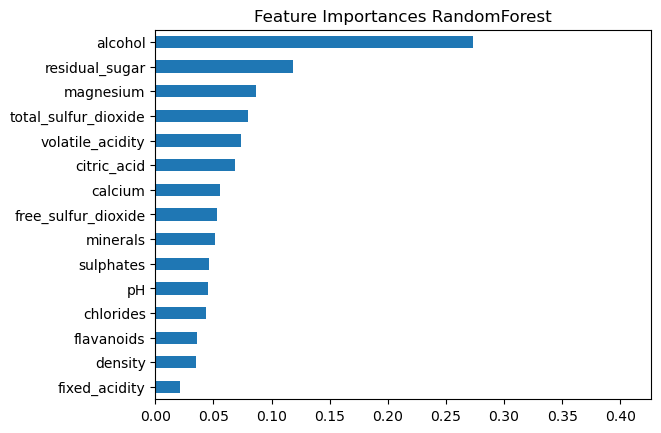

In [54]:
rfc = RandomForestRegressor(random_state=42)

for pipeline in pipelines:
    print("________________________")
    print(f"Input dataframe: {pipeline['input_df']}, Preprocessing: {pipeline['preprocessing_steps']}")


    rfc.fit(pipeline['X_train'], pipeline['y_train'])

    y_pred = rfc.predict(pipeline['X_test'])

    # Calculate the mean squared error and R-squared
    mse = mean_squared_error(pipeline['y_test'], y_pred)
    r2 = r2_score(pipeline['y_test'], y_pred)
    write_to_log_file(f"MSE: {mse}")
    write_to_log_file(f"R2: {r2}")
    feat_importances = pd.Series(rfc.feature_importances_, index = pipeline['X_train'].columns).sort_values(ascending = True)
    feat_importances.plot(kind = 'barh')
    plt.title('Feature Importances RandomForest')
    print("\n")


# Test Clean dataframe

In [55]:
model_rf = RandomForestRegressor(random_state = 42).fit(pipeline3_clean['X_train'], pipeline3_clean['y_train'])
y_pred_rf = model_rf.predict(pipeline3_clean['X_test'])
y_pred_rf

array([5.75, 5.37, 5.98, 4.93, 6.68, 5.63, 1.96, 5.7 , 5.85, 5.3 , 5.36,
       6.16, 6.5 , 5.92, 5.27, 6.8 , 5.19, 6.6 , 5.73, 5.19, 6.55, 6.08,
       6.14, 5.19, 5.3 , 5.61, 5.78, 5.95, 6.48, 5.27, 6.35, 6.62, 5.61,
       5.33, 6.07, 6.27, 6.11, 6.08, 5.63, 5.49, 5.56, 6.52, 5.79, 5.98,
       6.05, 6.31, 5.32, 6.37, 6.21, 6.1 , 5.92, 6.23, 5.94, 6.26, 5.36,
       5.66, 6.07, 6.26, 6.88, 6.65, 5.26, 6.3 , 6.07, 5.77, 5.61, 6.07,
       6.58, 6.63, 6.29, 5.95, 6.03, 5.22, 6.62, 5.22, 6.43, 6.01, 6.28,
       5.76, 5.36, 5.91, 1.93, 6.38, 5.17, 5.75, 5.81, 5.95, 6.52, 5.35,
       6.55, 6.15, 5.63, 5.46, 5.4 , 6.75, 5.81, 5.4 , 6.84, 5.09, 6.17,
       6.54, 5.92, 5.67, 5.34, 6.64, 5.95, 6.17, 4.88, 5.42, 5.99, 6.94,
       1.59, 5.75, 6.45, 1.5 , 6.35, 5.11, 6.17, 7.68, 6.04, 5.85, 5.42,
       5.86, 6.67, 5.83, 6.92, 6.2 , 6.06, 5.51, 5.36, 6.34, 5.43, 5.57,
       5.14, 5.24, 6.3 , 6.1 , 6.56, 4.75, 6.36, 6.06, 5.87, 5.24, 5.89,
       5.58, 5.27, 5.79, 6.4 , 5.6 , 6.02, 5.49, 5.

In [56]:
rfc = RandomForestRegressor(random_state=42)

n_estimators = [1600]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [57]:
random_search = RandomizedSearchCV(estimator = rfc,  param_distributions = params_grid, verbose = 1, cv = 2, n_iter = 100, random_state = 42, n_jobs = -1)

random_search.fit(pipeline3_clean['X_train'], pipeline3_clean['y_train'])

Fitting 2 folds for each of 100 candidates, totalling 200 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1600]},
                   random_state=42, verbose=1)

In [58]:
write_to_log_file(f'best: {random_search.best_params_}')

best: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}


In [59]:
rf_rs = RandomForestRegressor(**random_search.best_params_)
# n_estimators = 1600, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 80, bootstrap = False, random_state = 42

model_rf_rs = rf_rs.fit(pipeline3_clean['X_train'].drop(columns=[ 'magnesium','flavanoids', 'minerals', 'calcium']), pipeline3_clean['y_train'].drop(columns=[ 'magnesium','flavanoids', 'minerals', 'calcium']))

y_pred_rf_rs = model_rf_rs.predict(pipeline3_clean['X_test'].drop(columns=[ 'magnesium','flavanoids', 'minerals', 'calcium']))

In [60]:
y_test = pipeline3_clean['y_test']
write_to_log_file('Score MAE for  RF:        {:.4f}' .format(mean_absolute_error(y_test, y_pred_rf)))
write_to_log_file('Score MAPE for RF:        {:.4f}' .format(mean_absolute_percentage_error(y_test, y_pred_rf)))
write_to_log_file('Score MSE for  RF:        {:.4f}' .format(mean_squared_error(y_test, y_pred_rf, squared = True)))
write_to_log_file('Score RMSE for RF:        {:.4f}' .format(mean_squared_error(y_test, y_pred_rf, squared = False)))
write_to_log_file(60*'-')
write_to_log_file('Score MAE for  Tuned RF:  {:.4f}' .format(mean_absolute_error(y_test, y_pred_rf_rs)))
write_to_log_file('Score MAPE for Tuned RF:  {:.4f}' .format(mean_absolute_percentage_error(y_test, y_pred_rf_rs)))
write_to_log_file('Score MSE for  Tuned RF:  {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_rs, squared = True)))
write_to_log_file('Score RMSE for Tuned RF:  {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_rs, squared = False)))

Score MAE for  RF:        0.4843
Score MAPE for RF:        0.0906
Score MSE for  RF:        0.4021
Score RMSE for RF:        0.6341
------------------------------------------------------------
Score MAE for  Tuned RF:  0.4477
Score MAPE for Tuned RF:  0.0840
Score MSE for  Tuned RF:  0.3648
Score RMSE for Tuned RF:  0.6040


In [61]:
df_display = pipeline3_clean['X_test'].copy()
df_display = df_display.drop(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'magnesium','flavanoids', 'minerals', 'calcium', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'], axis= 1)
df_display['real quality'] = y_test
df_display['rf pred'] = y_pred_rf
df_display['tuned rf pred'] = y_pred_rf_rs
df_display.tail(15)

,Cabernet Sauvignon,Chardonnay,Gamay,Merlot,Pinot noir,real quality,rf pred,tuned rf pred
1821,0.0,0.0,0.0,0.0,1.0,7,6.19,6.128125
3270,0.0,0.0,0.0,0.0,1.0,7,6.51,6.644375
165,1.0,0.0,0.0,0.0,0.0,6,6.16,6.110625
1333,0.0,0.0,0.0,1.0,0.0,6,6.05,6.065000
3759,0.0,0.0,0.0,1.0,0.0,6,5.10,5.093125
413,0.0,1.0,0.0,0.0,0.0,5,5.31,5.347500
3058,1.0,0.0,0.0,0.0,0.0,5,5.43,5.330000
630,0.0,0.0,0.0,0.0,1.0,6,5.48,5.578750
3228,0.0,0.0,0.0,1.0,0.0,5,6.13,6.005000
2148,1.0,0.0,0.0,0.0,0.0,5,5.36,5.246250


# Test No Gamay dataframe

In [62]:
model_rf_ngm = RandomForestRegressor(random_state = 42).fit(pipeline3_no_gamay['X_train'], pipeline3_no_gamay['y_train'])
y_pred_rf_ngm = model_rf_ngm.predict(pipeline3_no_gamay['X_test'])
y_pred_rf_ngm

array([6.03, 5.85, 6.71, 5.33, 6.77, 5.92, 5.79, 5.38, 5.16, 5.5 , 5.8 ,
       5.31, 5.6 , 5.91, 6.71, 6.42, 5.34, 5.25, 6.4 , 6.  , 4.8 , 6.27,
       6.  , 5.05, 5.76, 5.35, 6.41, 5.58, 5.32, 5.5 , 6.32, 5.54, 5.48,
       5.84, 5.71, 6.  , 6.69, 5.22, 6.55, 6.25, 5.72, 6.81, 5.88, 6.59,
       6.1 , 6.76, 6.58, 5.63, 5.33, 5.35, 5.97, 5.23, 5.89, 5.12, 6.23,
       5.76, 5.34, 6.09, 5.27, 6.38, 4.93, 6.07, 6.62, 6.28, 6.23, 5.64,
       5.71, 6.58, 5.89, 6.19, 6.  , 6.33, 5.89, 5.39, 4.94, 4.89, 5.28,
       5.44, 5.48, 6.39, 5.72, 5.27, 5.39, 6.18, 5.83, 5.86, 5.65, 6.72,
       5.74, 6.14, 6.99, 6.11, 6.51, 5.36, 5.45, 6.15, 5.32, 5.85, 6.15,
       6.79, 5.63, 5.16, 6.55, 4.54, 5.34, 5.68, 6.27, 5.47, 6.57, 5.79,
       5.71, 4.93, 5.32, 6.55, 6.11, 5.34, 6.4 , 5.36, 5.82, 6.  , 5.42,
       5.93, 5.11, 6.16, 5.79, 6.67, 6.5 , 5.68, 5.65, 5.5 , 5.53, 6.74,
       6.54, 7.02, 5.81, 5.86, 5.22, 5.17, 5.95, 5.43, 5.87, 6.07, 6.45,
       5.79, 5.22, 5.32, 5.82, 6.48, 5.41, 6.01, 6.

In [63]:
rfc = RandomForestRegressor(random_state=42)

n_estimators = [1400, 1600, 1800]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [64]:
random_search = RandomizedSearchCV(estimator = rfc,  param_distributions = params_grid, verbose = 1, cv = 5, n_iter = 100, random_state = 42, n_jobs = -1)

random_search.fit(pipeline3_no_gamay['X_train'], pipeline3_no_gamay['y_train'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1400, 1600, 1800]},
                   random_state=42, verbose=1)

# Final model No Gamay

Dropping 'magnesium', 'flavanoids', 'minerals', 'calcium' to further improve model based on Task 1 Data Exploration

In [65]:
write_to_log_file(f'best: {random_search.best_params_}')

best: {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 70, 'bootstrap': False}


In [66]:
rf_rs = RandomForestRegressor(**random_search.best_params_)
# n_estimators = 1600, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 80, bootstrap = False, random_state = 42

model_rf_rs = rf_rs.fit(pipeline3_no_gamay['X_train'].drop(columns=[ 'magnesium','flavanoids', 'minerals', 'calcium']), pipeline3_no_gamay['y_train'].drop(columns=[ 'magnesium','flavanoids', 'minerals', 'calcium']))

# save model
filename_ng = 'finalized_model_no_gamay.sav'
joblib.dump(model, filename_ng)

y_pred_rf_ngm_rs = model_rf_rs.predict(pipeline3_no_gamay['X_test'].drop(columns=[ 'magnesium','flavanoids', 'minerals', 'calcium']))

In [67]:
y_test = pipeline3_no_gamay['y_test']
write_to_log_file('Score MAE for  RF:        {:.4f}' .format(mean_absolute_error(y_test, y_pred_rf_ngm)))
write_to_log_file('Score MAPE for RF:        {:.4f}' .format(mean_absolute_percentage_error(y_test, y_pred_rf_ngm)))
write_to_log_file('Score MSE for  RF:        {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_ngm, squared = True)))
write_to_log_file('Score RMSE for RF:        {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_ngm, squared = False)))
write_to_log_file(60*'-')
write_to_log_file('Score MAE for  Tuned RF:  {:.4f}' .format(mean_absolute_error(y_test, y_pred_rf_ngm_rs)))
write_to_log_file('Score MAPE for Tuned RF:  {:.4f}' .format(mean_absolute_percentage_error(y_test, y_pred_rf_ngm_rs)))
write_to_log_file('Score MSE for  Tuned RF:  {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_ngm_rs, squared = True)))
write_to_log_file('Score RMSE for Tuned RF:  {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_ngm_rs, squared = False)))

Score MAE for  RF:        0.4742
Score MAPE for RF:        0.0836
Score MSE for  RF:        0.3780
Score RMSE for RF:        0.6148
------------------------------------------------------------
Score MAE for  Tuned RF:  0.3964
Score MAPE for Tuned RF:  0.0701
Score MSE for  Tuned RF:  0.3155
Score RMSE for Tuned RF:  0.5617


In [68]:
df_display = pipeline3_no_gamay['X_test'].copy()
df_display = df_display.drop(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'magnesium','flavanoids', 'minerals', 'calcium', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'], axis= 1)
df_display['real quality'] = y_test
df_display['rf pred'] = y_pred_rf_ngm
df_display['tuned rf pred'] = y_pred_rf_ngm_rs
df_display.tail(15)

,Cabernet Sauvignon,Chardonnay,Merlot,Pinot noir,real quality,rf pred,tuned rf pred
3004,1.0,0.0,0.0,0.0,5,5.84,5.947143
3158,0.0,0.0,0.0,1.0,5,5.97,6.054286
2573,0.0,0.0,0.0,1.0,7,7.02,6.984286
33,0.0,0.0,0.0,1.0,5,5.96,5.881429
861,0.0,0.0,0.0,1.0,6,5.79,5.645714
2849,0.0,1.0,0.0,0.0,6,6.02,5.847143
1740,0.0,0.0,0.0,1.0,7,6.98,6.954286
609,0.0,0.0,0.0,1.0,4,4.79,4.297857
3117,0.0,1.0,0.0,0.0,7,6.94,6.715000
3824,1.0,0.0,0.0,0.0,7,6.92,7.011429


# Gamay



In [69]:
model_rf_gm = RandomForestRegressor(random_state = 42).fit(pipeline3_gamay['X_train'], pipeline3_gamay['y_train'])
y_pred_rf_gm = model_rf_gm.predict(pipeline3_gamay['X_test'])
y_pred_rf_gm

array([1.91, 1.67, 1.99, 1.92, 1.37, 1.94, 1.42, 1.91, 1.89, 1.96, 1.88,
       1.71, 2.  , 1.32, 1.58, 1.66, 1.8 , 1.66, 1.62, 1.73, 1.66, 1.7 ,
       1.54])

In [70]:
rfc = RandomForestRegressor(random_state=42)

n_estimators = [1400, 1600, 1800]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [71]:
random_search_gamay = RandomizedSearchCV(estimator = rfc,  param_distributions = params_grid, verbose = 1, cv = 5, n_iter = 100, random_state = 42, n_jobs = -1)

random_search_gamay.fit(pipeline3_gamay['X_train'], pipeline3_gamay['y_train'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1400, 1600, 1800]},
                   random_state=42, verbose=1)

# Final Gamay model

Dropping 'magnesium', 'flavanoids', 'minerals', 'calcium' to further improve model based on Task 1 Data Exploration

In [72]:
write_to_log_file(f'best: {random_search_gamay.best_params_}')

best: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}


In [73]:
rf_rs_gamay = RandomForestRegressor(**random_search_gamay.best_params_)
# n_estimators = 1600, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 80, bootstrap = False, random_state = 42

model_rf_rs_gm = rf_rs_gamay.fit(pipeline3_gamay['X_train'].drop(columns=[ 'magnesium','flavanoids', 'minerals', 'calcium']), pipeline3_gamay['y_train'].drop(columns=[ 'magnesium','flavanoids', 'minerals', 'calcium']))

# save model
filename_g = 'finalized_model_gamay.sav'
joblib.dump(model, filename_g)

y_pred_rf_gm_rs = model_rf_rs_gm.predict(pipeline3_gamay['X_test'].drop(columns=[ 'magnesium','flavanoids', 'minerals', 'calcium']))

In [74]:
y_test = pipeline3_gamay['y_test']
write_to_log_file('Score MAE for  RF:        {:.4f}' .format(mean_absolute_error(y_test, y_pred_rf_gm)))
write_to_log_file('Score MAPE for RF:        {:.4f}' .format(mean_absolute_percentage_error(y_test, y_pred_rf_gm)))
write_to_log_file('Score MSE for  RF:        {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_gm, squared = True)))
write_to_log_file('Score RMSE for RF:        {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_gm, squared = False)))
write_to_log_file(60*'-')
write_to_log_file('Score MAE for  Tuned RF:  {:.4f}' .format(mean_absolute_error(y_test, y_pred_rf_gm_rs)))
write_to_log_file('Score MAPE for Tuned RF:  {:.4f}' .format(mean_absolute_percentage_error(y_test, y_pred_rf_gm_rs)))
write_to_log_file('Score MSE for  Tuned RF:  {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_gm_rs, squared = True)))
write_to_log_file('Score RMSE for Tuned RF:  {:.4f}' .format(mean_squared_error(y_test, y_pred_rf_gm_rs, squared = False)))

Score MAE for  RF:        0.3643
Score MAPE for RF:        0.2824
Score MSE for  RF:        0.2063
Score RMSE for RF:        0.4542
------------------------------------------------------------
Score MAE for  Tuned RF:  0.3894
Score MAPE for Tuned RF:  0.2993
Score MSE for  Tuned RF:  0.2115
Score RMSE for Tuned RF:  0.4599


In [75]:
df_display_gamay = pipeline3_gamay['X_test'].copy()
df_display_gamay = df_display_gamay.drop(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'magnesium','flavanoids', 'minerals', 'calcium', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'], axis= 1)
df_display_gamay['real quality'] = y_test
df_display_gamay['rf pred'] = y_pred_rf_gm
df_display_gamay['tuned rf pred'] = y_pred_rf_gm_rs
df_display_gamay.tail(15)

,real quality,rf pred,tuned rf pred
1236,2,1.89,1.952778
3478,2,1.96,1.805185
1829,2,1.88,1.774444
446,2,1.71,1.691932
1906,2,2.00,1.909921
1819,2,1.32,1.495300
2559,1,1.58,1.578704
3594,2,1.66,1.602222
108,1,1.80,1.761810
1192,1,1.66,1.816667


# Conclusion

Our final models are saved in
- 'finalized_model_gamay.sav': Score MSE for RandomforestRegressor:  0.2115
- 'finalized_model_no_gamay.sav': Score MSE for RandomforestRegressor:  0.3155

In comparison to our baseline model: MSE between roundabout 122 and 264